In [1]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from torchvision.utils import save_image

seed = 7

random.seed(seed)

In [2]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)

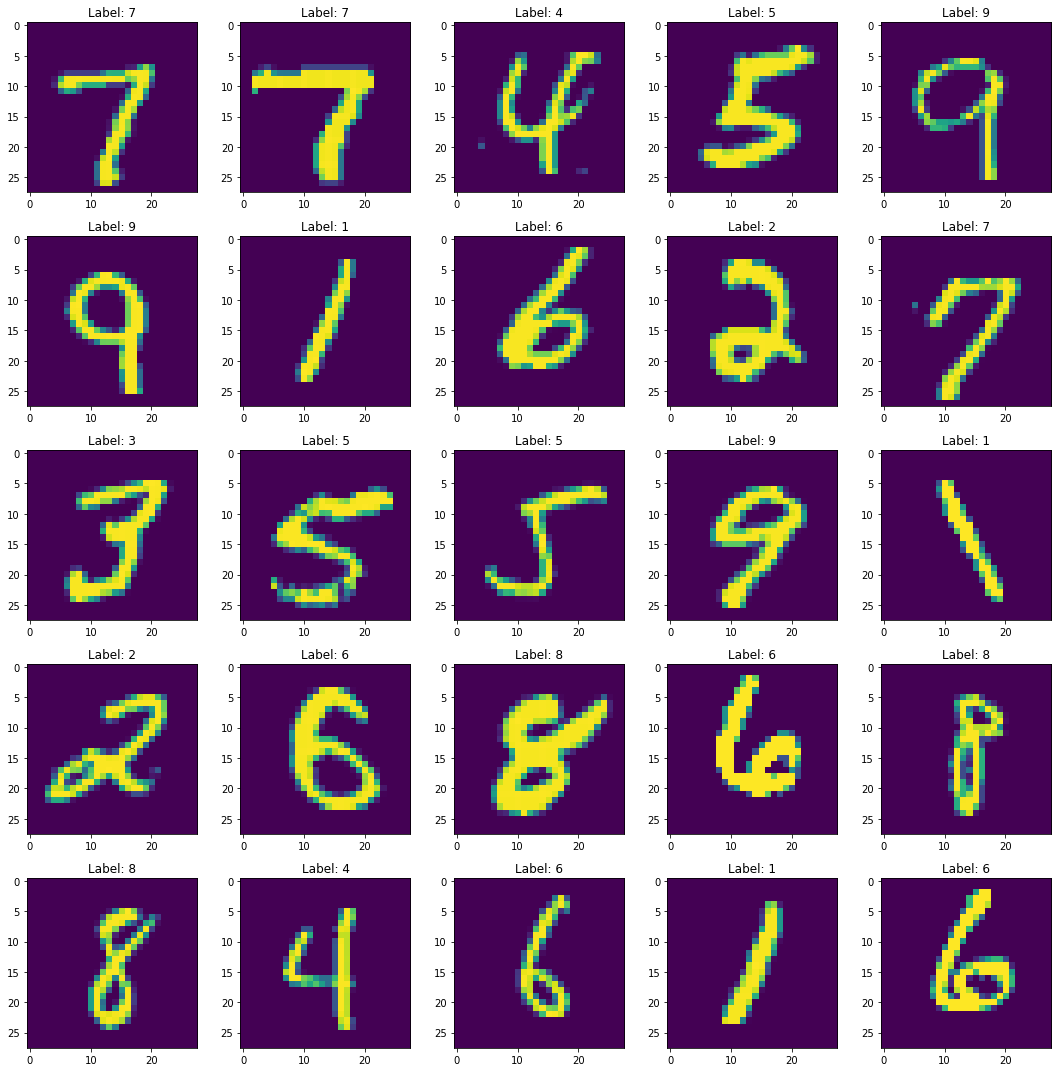

In [3]:
nb_images = 25
divs = int(nb_images / 5)
idx_imgs = random.sample(range(len(mnist_train)), nb_images)

fig = plt.figure(figsize=(15,15))
for idx, val in enumerate(idx_imgs, 1):
    target, label = mnist_train[val]
    ax = fig.add_subplot(5,divs,idx)
    ax.imshow(np.asarray(target.getdata()).reshape(28,28))
    ax.set_title("Label: {}".format(label))


plt.tight_layout()
plt.show()

In [4]:
latent_dim = 30
img_shape = target.size

In [5]:
#Generator

class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(in_features, out_features, normalize=True):
            
            layers = [torch.nn.Linear(in_features, out_features)]
            if normalize:
                layers.append(torch.nn.BatchNorm1d(out_features, 0.8))
            layers.append(torch.nn.LeakyReLU(0.2, inplace=True))
            
            return layers
        
        self.model = torch.nn.Sequential(
                                         *block(latent_dim, 128, normalize=False ),
                                         *block(128,256),
                                         *block(256,512), 
                                         *block(512,1024), 
                                         *block(1024, int(np.prod(img_shape))) #dimension of resulting image
                                        )
        
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape) #resize image to 28x28
        
        return img
    
class Discriminantor(torch.nn.Module):
    
    def __init__(self):
        super(Discriminantor, self).__init__()
        
        self.model = torch.nn.Sequential(torch.nn.Linear(int(np.prod(img_shape)), 512),
                                         torch.nn.LeakyReLU(0.2, inplace=True),
                                         torch.nn.Linear(512, 256),
                                         torch.nn.LeakyReLU(0.2, inplace=True),
                                         torch.nn.Linear(256, 1),
                                         torch.nn.Sigmoid()
                                        )
        
    def forward(self, img):
        flatten_img = img.view(img.size(0), -1)
        output = self.model(flatten_img)
        
        return output



In [6]:
discriminator = Discriminantor()
generator = Generator()
loss = torch.nn.BCELoss()

discriminator.cuda()
generator.cuda()
loss.cuda()

BCELoss()

In [7]:
#reloading dataset with transforms
train_transformer = transforms.Compose([transforms.Resize(img_shape), 
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5], [0.5])])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transformer)

mnist_loader = torch.utils.data.DataLoader(mnist_train, batch_size=16, shuffle=True)

In [8]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.00008,betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00008, betas=(0.5, 0.999))

In [9]:
Tensor = torch.cuda.FloatTensor

In [11]:
for epoch in range(400):
    for idx, (imgs, label) in enumerate(mnist_loader):
        
        
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        
        real_imgs = Variable(imgs.type(Tensor))
        
        optimizer_G.zero_grad()
        
        #random noise
        z = Variable(Tensor(np.random.normal(0,1,(imgs.shape[0], latent_dim))))
        
        generate_images = generator(z)
        
        g_loss = loss(discriminator(generate_images), valid)
        g_loss.backward()
        optimizer_G.step()
        
        optimizer_D.zero_grad()
        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = loss(discriminator(real_imgs), valid)
        fake_loss = loss(discriminator(generate_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        

        batches_done = epoch * len(mnist_loader) + idx
        if batches_done % 5000== 0:
            print("[Epoch %d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, idx, len(mnist_loader), d_loss.item(), g_loss.item()))
            print(generate_images.data[:15].shape)
            save_image(generate_images.data[:15].view(15, 1, 28, 28), "IMAGES/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0] [Batch 0/3750] [D loss: 0.634092] [G loss: 0.714083]
torch.Size([15, 28, 28])
[Epoch 1] [Batch 1250/3750] [D loss: 0.000019] [G loss: 10.188805]
torch.Size([15, 28, 28])
[Epoch 2] [Batch 2500/3750] [D loss: 0.000001] [G loss: 13.304735]
torch.Size([15, 28, 28])
[Epoch 4] [Batch 0/3750] [D loss: 0.000115] [G loss: 9.466421]
torch.Size([15, 28, 28])
[Epoch 5] [Batch 1250/3750] [D loss: 0.000016] [G loss: 12.616011]
torch.Size([15, 28, 28])
[Epoch 6] [Batch 2500/3750] [D loss: 0.000019] [G loss: 21.312481]
torch.Size([15, 28, 28])
[Epoch 8] [Batch 0/3750] [D loss: 0.000040] [G loss: 18.516613]
torch.Size([15, 28, 28])
[Epoch 9] [Batch 1250/3750] [D loss: 0.000038] [G loss: 15.597178]
torch.Size([15, 28, 28])
[Epoch 10] [Batch 2500/3750] [D loss: 0.000588] [G loss: 12.363369]
torch.Size([15, 28, 28])
[Epoch 12] [Batch 0/3750] [D loss: 0.001020] [G loss: 11.146584]
torch.Size([15, 28, 28])
[Epoch 13] [Batch 1250/3750] [D loss: 0.005936] [G loss: 11.100853]
torch.Size([15, 28, 28])

[Epoch 120] [Batch 0/3750] [D loss: 0.015222] [G loss: 7.037615]
torch.Size([15, 28, 28])
[Epoch 121] [Batch 1250/3750] [D loss: 0.077529] [G loss: 4.863024]
torch.Size([15, 28, 28])
[Epoch 122] [Batch 2500/3750] [D loss: 0.043433] [G loss: 3.478041]
torch.Size([15, 28, 28])
[Epoch 124] [Batch 0/3750] [D loss: 0.080821] [G loss: 2.705764]
torch.Size([15, 28, 28])
[Epoch 125] [Batch 1250/3750] [D loss: 0.003894] [G loss: 8.287157]
torch.Size([15, 28, 28])
[Epoch 126] [Batch 2500/3750] [D loss: 0.018714] [G loss: 5.563638]
torch.Size([15, 28, 28])
[Epoch 128] [Batch 0/3750] [D loss: 0.032411] [G loss: 6.912724]
torch.Size([15, 28, 28])
[Epoch 129] [Batch 1250/3750] [D loss: 0.023926] [G loss: 4.461737]
torch.Size([15, 28, 28])
[Epoch 130] [Batch 2500/3750] [D loss: 0.027048] [G loss: 7.472280]
torch.Size([15, 28, 28])
[Epoch 132] [Batch 0/3750] [D loss: 0.019842] [G loss: 8.212526]
torch.Size([15, 28, 28])
[Epoch 133] [Batch 1250/3750] [D loss: 0.020063] [G loss: 5.144416]
torch.Size([15

[Epoch 238] [Batch 2500/3750] [D loss: 0.019723] [G loss: 7.085289]
torch.Size([15, 28, 28])
[Epoch 240] [Batch 0/3750] [D loss: 0.005764] [G loss: 5.468681]
torch.Size([15, 28, 28])
[Epoch 241] [Batch 1250/3750] [D loss: 0.033210] [G loss: 3.802906]
torch.Size([15, 28, 28])
[Epoch 242] [Batch 2500/3750] [D loss: 0.029335] [G loss: 4.776557]
torch.Size([15, 28, 28])
[Epoch 244] [Batch 0/3750] [D loss: 0.004680] [G loss: 7.374445]
torch.Size([15, 28, 28])
[Epoch 245] [Batch 1250/3750] [D loss: 0.052815] [G loss: 8.083751]
torch.Size([15, 28, 28])
[Epoch 246] [Batch 2500/3750] [D loss: 0.000073] [G loss: 10.669361]
torch.Size([15, 28, 28])
[Epoch 248] [Batch 0/3750] [D loss: 0.035129] [G loss: 5.592804]
torch.Size([15, 28, 28])
[Epoch 249] [Batch 1250/3750] [D loss: 0.051133] [G loss: 6.875348]
torch.Size([15, 28, 28])
[Epoch 250] [Batch 2500/3750] [D loss: 0.007761] [G loss: 7.073689]
torch.Size([15, 28, 28])
[Epoch 252] [Batch 0/3750] [D loss: 0.035313] [G loss: 10.269648]
torch.Size([

[Epoch 357] [Batch 1250/3750] [D loss: 0.000207] [G loss: 12.448511]
torch.Size([15, 28, 28])
[Epoch 358] [Batch 2500/3750] [D loss: 0.053950] [G loss: 14.135714]
torch.Size([15, 28, 28])
[Epoch 360] [Batch 0/3750] [D loss: 0.001891] [G loss: 12.576874]
torch.Size([15, 28, 28])
[Epoch 361] [Batch 1250/3750] [D loss: 0.003593] [G loss: 7.487766]
torch.Size([15, 28, 28])
[Epoch 362] [Batch 2500/3750] [D loss: 0.036508] [G loss: 15.577401]
torch.Size([15, 28, 28])
[Epoch 364] [Batch 0/3750] [D loss: 0.001482] [G loss: 7.620702]
torch.Size([15, 28, 28])
[Epoch 365] [Batch 1250/3750] [D loss: 0.016660] [G loss: 5.614293]
torch.Size([15, 28, 28])
[Epoch 366] [Batch 2500/3750] [D loss: 0.008191] [G loss: 10.852326]
torch.Size([15, 28, 28])
[Epoch 368] [Batch 0/3750] [D loss: 0.011596] [G loss: 6.723801]
torch.Size([15, 28, 28])
[Epoch 369] [Batch 1250/3750] [D loss: 0.046648] [G loss: 4.315111]
torch.Size([15, 28, 28])
[Epoch 370] [Batch 2500/3750] [D loss: 0.014870] [G loss: 17.435692]
torch